# Batched input with geolocated data
In this tutorial, we will be using the `urbanworm.dataset` module to collect geo-located data, including Mapillary street views, Flickr photos, and Freesound recordings. The `urbanworm.inference` module will be used to inference with InternVL3-8B-Instruct and Qwen2.5-Omni for imagery and audio data.

We will be using three case studies to demonstrate what insight may be gained from these datasets:
1) case study (in Detroit) using street views: Does the house look occupied?
2) case study (in Hongkong) using Flickr photos: What was captured in the photo?
3) case study (in Tokyo) using Freesound recordings: Did you hear the wind?

For each case study, We follow the following steps:
1) Query and process data
2) Download the dataset
3) Pass the dataset constructor to inference constructor
4) Batch inference

Retrieving data will require api keys of Mapillary, Flickr, and Freesound, which can be requested from:
- https://www.mapillary.com/developer/api-documentation
- https://www.flickr.com/services/api/
- https://freesound.org/apiv2/apply

Note:
- To see all the available street views on Mapillary, please check out [Mapillary Map App](https://www.mapillary.com/app/?lat=20&lng=0&z=1.6875)
- To see all the available geo-tagged photos on Flickr, please check out [everyone's photo on the map](https://www.flickr.com/map)
- To see all the available geo-tagged recordings on Freesound, please check out [the map of sounds](https://freesound.org/browse/geotags/?c_lat=24&c_lon=20&z=2)

In [1]:
from urbanworm.dataset import GeoTaggedData
from urbanworm.inference.llama import InferenceLlamacpp

In [2]:
# Import api keys
with open("mapillary_key.txt", 'r') as file:
    mapillary_key = file.read()
with open("flickr_key.txt", 'r') as file:
    flickr_key = file.read()
with open("freesound_key.txt", 'r') as file:
    freesound_key = file.read()

## 1 Does the house look occupied?

### 1.1 Retrieve street views at property-level

Building footprints will be used as proximity for gathering the data.

In [3]:
# get building footprints from OSM

# Initiate the constructor
gtd = GeoTaggedData()
# Define the area of interest using a bounding box (bbox)
bbox = (-83.208003,42.374646,-83.206608,42.375328) # in Detroit, USA
# we can just get house with no more than 200 square meter (single family houses with garage excluded)
gtd.getBuildings(bbox, min_area=60, max_area=200)

14 buildings found in the bounding box.


<Axes: >

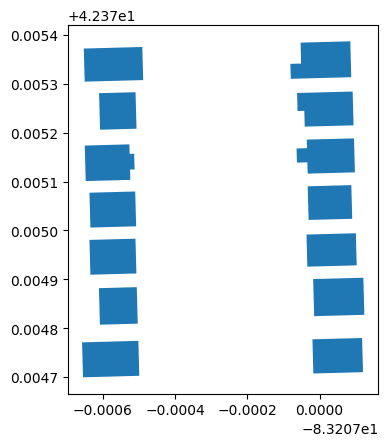

In [4]:
gtd.units.plot()

For each house location, we find nearby (≤30 m) panoramic Mapillary images, picks up to 3 that are not too close together in sequence, and outputs 90° perspective crops that are reoriented to center on the house.

In [4]:
gtd.get_svi_from_locations(key = mapillary_key, # api key
                           distance = 30,       # only search for available street view with 30 meters from the house location
                           pano = True,         # only search for 360-degree street view images
                           reoriented = True,   # reorient and crop the street view images to make them only frame the house at the center of scene
                           multi_num = 3,       # return three closest street views from the house location
                           fov = 80,            # The field of view in degrees for the reoriented images
                           interval = 2,        # The interval between each street view (i.g, `interval = 2` means there should be two available images between two collected images)
                           year = (2024, 2025), # only search for images captured between 2024 and 2025
                           time_of_day = 'day'  # only search for images captured during the daytime
                           )

  0%|          | 0/14 [00:00<?, ?it/s]

The metadata is stored in the constructor, including:
- mapillary image id,
- sequence id,
- when it was captured,
- the original orientation angle,
- image coordinates,
- and the house location index.

In [8]:
gtd.svi_metadata.head(5)

,id,sequence,captured_at,compass_angle,image_lon,image_lat,url,loc_id
0,1009175311394842,ThVwcIdPek1fQ6z4Dbv3KJ,2025-5-5-17,268.39,-83.206960,42.374651,https://scontent-det1-1.xx.fbcdn.net/m1/v/t6/A...,0
1,1223726255791358,ThVwcIdPek1fQ6z4Dbv3KJ,2025-5-5-17,268.57,-83.206838,42.374655,https://scontent-det1-1.xx.fbcdn.net/m1/v/t6/A...,0
2,1261874768838904,ThVwcIdPek1fQ6z4Dbv3KJ,2025-5-5-17,267.95,-83.207081,42.374648,https://scontent-det1-1.xx.fbcdn.net/m1/v/t6/A...,0
0,1009175311394842,ThVwcIdPek1fQ6z4Dbv3KJ,2025-5-5-17,268.39,-83.206960,42.374651,https://scontent-det1-1.xx.fbcdn.net/m1/v/t6/A...,1
1,1223726255791358,ThVwcIdPek1fQ6z4Dbv3KJ,2025-5-5-17,268.57,-83.206838,42.374655,https://scontent-det1-1.xx.fbcdn.net/m1/v/t6/A...,1


The data information is also stored in a dictionary format for data downloading and processing in the future.

In this case study, since the image has been reoriented and cropped, the images have been store in base64 format inside the dataset constructor.

In [10]:
gtd.svis['loc_id'][0], gtd.svis['id'][0], gtd.svis['data'][0][:500]

(0,
 '1009175311394842',
 'iVBORw0KGgoAAAANSUhEUgAAArwAAAH0CAIAAABQO2mIAAAgAElEQVR4AezBCdSld0Em+Of5v+vd77cvtS+pVGUlCSEJISwBZVFAGpVBW0fsmXaZse3Rc2bsHrtPj4N6WsFxnN5s5ygytqA2jYAggqwJBJCEVJZKbam9vv377n7f+27/Z27dyldUpSohtjNndLp+P+bWAsQmCaBISLkEQxeAtSJBEpskkLiIxJAECaAFwCEQI4JkSeISCVcjMSThciRISPiOCOEqkgBwBFexEK6FIDYJwlUICRoiAQgXOJCRQIKEBAmgAHEItLIcAgVhRBIAQwNAEJ5HxFVISCAhYYiEIIJWFgCHQEG4kiwxQiNciaCgIZL46yMoiCAACc9DQsKQBGNgLUiQkEBCwhAJQXgBBK0sAAECSAIwEkiCVpZDoCAABHEtxP8LBBAQQAhXIP4/phEaI2gIhIERhBGCgggCEIT/h0jCiGislTG0VsbQWllrXdeR')

### 1.2 Download data (optional but recommended)
For batched image inference, working with local data can be usually more stable than streaming data. Therefore, downloading data (images or sound recordings) to a directory is highly recommended but optional.

In [ ]:
gtd.download_to_dir(data='svi',
                    to_dir='/svi_download',
                    prefix='svi')
# after downloading all images, the local path of images will be stored, which allows the inference constructor to access local images
gtd.svis['path'][:5]

### 1.3 Pass to the inference constructor

In [5]:
# indicate that the street view images wil be used
gtd.set_images('svi')
# pass the dataset to the inference constructor
data = InferenceLlamacpp(geo_tagged_data=gtd)

In [6]:
# pack images by their sample locations
data.pack_by_location()

### 1.4 Batched inference

In [8]:
from typing import Literal

prompt = '''
    Question: Does this house look occupied if it is not a vacant lot?

    **An occupied house means that the house is not abandoned and
    some people may live in this house even if there is not people outside**
'''

# specify model
data.llm = 'ggml-org/InternVL3-8B-Instruct-GGUF:Q8_0'
# define output schema
data.schema = {"answer": (Literal['occupied', 'unoccupied', 'vacant'], ...),
               "explanation": (str, ...),}
# inference
data.batch_inference(prompt=prompt)

Processing...: 100%|███████████████████████| 13/13 [01:36<00:00,  7.40s/it]


,answer_1,explanation_1,data_1,data_2,data_3
0,occupied,The house has a well-maintained lawn and a fen...,/var/folders/fb/4kj6xrcs195bxml3gxcrrkq80000gn...,/var/folders/fb/4kj6xrcs195bxml3gxcrrkq80000gn...,/var/folders/fb/4kj6xrcs195bxml3gxcrrkq80000gn...
1,occupied,The house appears to be occupied because it is...,/var/folders/fb/4kj6xrcs195bxml3gxcrrkq80000gn...,/var/folders/fb/4kj6xrcs195bxml3gxcrrkq80000gn...,/var/folders/fb/4kj6xrcs195bxml3gxcrrkq80000gn...
2,occupied,The house in the image appears to be occupied ...,/var/folders/fb/4kj6xrcs195bxml3gxcrrkq80000gn...,/var/folders/fb/4kj6xrcs195bxml3gxcrrkq80000gn...,/var/folders/fb/4kj6xrcs195bxml3gxcrrkq80000gn...
3,occupied,"The house is not a vacant lot, so it is likely...",/var/folders/fb/4kj6xrcs195bxml3gxcrrkq80000gn...,/var/folders/fb/4kj6xrcs195bxml3gxcrrkq80000gn...,/var/folders/fb/4kj6xrcs195bxml3gxcrrkq80000gn...
4,occupied,"The house is not a vacant lot, so it is likely...",/var/folders/fb/4kj6xrcs195bxml3gxcrrkq80000gn...,/var/folders/fb/4kj6xrcs195bxml3gxcrrkq80000gn...,/var/folders/fb/4kj6xrcs195bxml3gxcrrkq80000gn...
5,occupied,"The house is not a vacant lot, so it is likely...",/var/folders/fb/4kj6xrcs195bxml3gxcrrkq80000gn...,/var/folders/fb/4kj6xrcs195bxml3gxcrrkq80000gn...,/var/folders/fb/4kj6xrcs195bxml3gxcrrkq80000gn...
6,occupied,"The house is not a vacant lot, so it is likely...",/var/folders/fb/4kj6xrcs195bxml3gxcrrkq80000gn...,/var/folders/fb/4kj6xrcs195bxml3gxcrrkq80000gn...,/var/folders/fb/4kj6xrcs195bxml3gxcrrkq80000gn...
7,occupied,"The house is not a vacant lot, so it is likely...",/var/folders/fb/4kj6xrcs195bxml3gxcrrkq80000gn...,/var/folders/fb/4kj6xrcs195bxml3gxcrrkq80000gn...,/var/folders/fb/4kj6xrcs195bxml3gxcrrkq80000gn...
8,occupied,"The house is not a vacant lot, so it is likely...",/var/folders/fb/4kj6xrcs195bxml3gxcrrkq80000gn...,/var/folders/fb/4kj6xrcs195bxml3gxcrrkq80000gn...,/var/folders/fb/4kj6xrcs195bxml3gxcrrkq80000gn...
9,occupied,The house in the image appears to be occupied ...,/var/folders/fb/4kj6xrcs195bxml3gxcrrkq80000gn...,/var/folders/fb/4kj6xrcs195bxml3gxcrrkq80000gn...,/var/folders/fb/4kj6xrcs195bxml3gxcrrkq80000gn...


## 2 What was captured in the photo?

### 2.1 Retrieve Flickr photos within a radius

In [3]:
# set a center point for spatially querying data
gtd = GeoTaggedData(locations=[[114.176773,22.302554]])
gtd.get_photo_from_location(key=flickr_key,
                            distance=1000, # only searching for data within the distance from the given center point
                            max_return=200, # only return the given number of photos
                            exclude_personal_photo = True, # drop personal photos using opencv/face_detection_yunet
                            )

  0%|          | 0/1 [00:00<?, ?it/s]

There are more than a half of photos detected as personal photos

In [8]:
len(gtd.photo_metadata)

93

The metadata is stored in the constructor, including:
- Flickr photo id,
- title of the sound,
- owner,
- when it was recorded,
- sound coordinates,
- ...

In [4]:
gtd.photo_metadata.head(5)

,loc_id,id,title,owner,datetaken,latitude,longitude,distance_m,tags,views,license,url
18,0,55039184398,"Observatory Road, Hong Kong / 天文臺道,香港",23502041@N06,2026-01-13 19:15:41,22.301397,114.174430,273.225805,,11,0,https://live.staticflickr.com/65535/5503918439...
115,0,55033921774,[Big Bee Taxi]Kaiyi X3 Pro EV WN4210,200369775@N04,2026-01-04 16:43:13,22.303136,114.180794,418.698089,,1,0,https://live.staticflickr.com/65535/5503392177...
78,0,55036639646,20260110 金利宝香港一日遊,30199947@N07,2026-01-10 13:43:11,22.301252,114.172058,506.210597,香港 金利寶 kongkong,20,0,https://live.staticflickr.com/65535/5503663964...
215,0,54993258227,IMG_7521,204002042@N04,2025-12-04 10:07:34,22.303761,114.171822,526.726446,,6,0,https://live.staticflickr.com/65535/5499325822...
212,0,54994140806,IMG_7519,204002042@N04,2025-12-04 10:02:15,22.303791,114.171830,526.791740,,8,0,https://live.staticflickr.com/65535/5499414080...


In [5]:
gtd.photos['id'][0], gtd.photos['data'][0]

('55039184398',
 'https://live.staticflickr.com/65535/55039184398_17460374cf_o.jpg')

### 2.2 Download data (optional but recommended)

In [9]:
# download data to directory
gtd.download_to_dir(data='photo',
                    to_dir='/Users/xiaohaoyang/Downloads/test_download',
                    prefix='test_download')

### 2.3 pass to the inference constructor

In [6]:
# indicate that the flickr photos wil be used
gtd.set_images('photo')
# pass the dataset to the inference constructor
data = InferenceLlamacpp(geo_tagged_data=gtd)

### 2.4 inference

In [13]:
from typing import Literal

prompt = '''
    please answer the following questions (make a guess) after seeing the photo:
    What is mian thing/focus capture in the photo and is this indoor or outdoor and dose the photo capture any outdoor urban or natural scenery?
'''

# specify model
data.llm = 'ggml-org/InternVL3-8B-Instruct-GGUF:Q8_0'
# define output schema
data.schema = {"focus": (str, ...),
               "indoor_outdoor": (Literal['indoor', 'outdoor'], ...),
               "scenery": (Literal['neither', 'urban', 'nature', 'both'], ...),}
# inference
result = data.batch_inference(prompt=prompt)
result.head(5)

Processing...: 100%|███████████████████████| 93/93 [09:03<00:00,  5.84s/it]


,focus_1,indoor_outdoor_1,scenery_1,data_1
0,The main focus of the photo is the brightly li...,indoor,urban,https://live.staticflickr.com/65535/5503918439...
1,The main focus of the photo is the busy urban ...,outdoor,urban,https://live.staticflickr.com/65535/5503392177...
2,"The main focus of the photo is the colorful, r...",outdoor,urban,https://live.staticflickr.com/65535/5503663964...
3,The main focus of the photo is a plate of food...,indoor,urban,https://live.staticflickr.com/65535/5499325822...
4,The main focus of the photo is a plate of food...,indoor,urban,https://live.staticflickr.com/65535/5499414080...


## 3 Did you hear the wind?

### 3.1 Retrieve Freesound recordings within a radius

In [9]:
# set a center point for spatially querying data
gtd = GeoTaggedData(locations=[[139.726978,35.658524]])
gtd.get_sound_from_location(key=freesound_key,
                            query='field_recording', # search for field recordings
                            distance=5000, #
                            max_return=200, #
                            duration=(20, 6000), # only search for recording with a duration between 15 and 6000 seconds
                            slice_duration=10, # need to mark the checkpoints every 10 second for clipping the sound
                            slice_max_num=2, # only need two clips from each sound
                            silent=False
                            )

  0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
len(gtd.audio_metadata)

41

In [11]:
gtd.audio_metadata.head(5)

,loc_id,id,name,username,license,created,duration,tags,geotag,latitude,...,url,page_url,description,num_downloads,avg_rating,slice,preview-hq-mp3,preview-hq-ogg,preview-lq-mp3,preview-lq-ogg
18,0,686617,Rapid Male Chanting in Temple in Japan,calebjay,https://creativecommons.org/licenses/by/4.0/,2023-05-10T07:47:39Z,28.7270,"[acapella, a-cappella, acappella, field-record...",35.64929634007673 139.74117500000023,35.649296,...,https://freesound.org/people/calebjay/sounds/6...,https://freesound.org/people/calebjay/sounds/6...,A man chanting in a temple in Japan. The templ...,151,5.000000,"[[0, 10000], [10000, 20000]]",https://cdn.freesound.org/previews/686/686617_...,https://cdn.freesound.org/previews/686/686617_...,https://cdn.freesound.org/previews/686/686617_...,https://cdn.freesound.org/previews/686/686617_...
1,0,135207,train from ebisu to shibuya 恵比寿,djgriffin,http://creativecommons.org/publicdomain/zero/1.0/,2011-11-19T06:20:01Z,160.5000,"[board, dr-1, ebisu, field, japan, platform, r...",35.6467 139.71012,35.646700,...,https://freesound.org/people/djgriffin/sounds/...,https://freesound.org/people/djgriffin/sounds/...,a field recording using the tascam dr-1 from e...,486,4.888889,"[[0, 10000], [10000, 20000]]",https://cdn.freesound.org/previews/135/135207_...,https://cdn.freesound.org/previews/135/135207_...,https://cdn.freesound.org/previews/135/135207_...,https://cdn.freesound.org/previews/135/135207_...
36,0,440606,Gong in zen buddhism,florianreichelt,http://creativecommons.org/publicdomain/zero/1.0/,2018-09-17T14:08:42Z,32.6200,"[bell, buddhism, buddhist, cymbal, drum, gong,...",35.6580390655 139.749506012,35.658039,...,https://freesound.org/people/florianreichelt/s...,https://freesound.org/people/florianreichelt/s...,We recorded this sound while our trip through ...,1093,4.277778,"[[0, 10000], [10000, 20000]]",https://cdn.freesound.org/previews/440/440606_...,https://cdn.freesound.org/previews/440/440606_...,https://cdn.freesound.org/previews/440/440606_...,https://cdn.freesound.org/previews/440/440606_...
38,0,440600,buddhsim monk is playing a gong in zen buddhism,florianreichelt,http://creativecommons.org/publicdomain/zero/1.0/,2018-09-17T14:08:32Z,38.1747,"[bang, bell, blacksmith, buddhism, clang, ding...",35.6577128899 139.749545429,35.657713,...,https://freesound.org/people/florianreichelt/s...,https://freesound.org/people/florianreichelt/s...,We recorded this sound while our trip through ...,203,4.888889,"[[0, 10000], [10000, 20000]]",https://cdn.freesound.org/previews/440/440600_...,https://cdn.freesound.org/previews/440/440600_...,https://cdn.freesound.org/previews/440/440600_...,https://cdn.freesound.org/previews/440/440600_...
33,0,799435,"Hie Shrine,Shichi-Go-San,Tsuri Taiko (Noise Fi...",Hinoki.owo,https://creativecommons.org/licenses/by/4.0/,2025-04-18T11:25:21Z,52.0000,"[ambiance, ambience, ambient, asia, background...",35.674787 139.739845,35.674787,...,https://freesound.org/people/Hinoki.owo/sounds...,https://freesound.org/people/Hinoki.owo/sounds...,"Late November of 2024, the visit of Hie Shrine...",13,5.000000,"[[0, 10000], [10000, 20000]]",https://cdn.freesound.org/previews/799/799435_...,https://cdn.freesound.org/previews/799/799435_...,https://cdn.freesound.org/previews/799/799435_...,https://cdn.freesound.org/previews/799/799435_...


In [5]:
gtd.audios['id'][0], gtd.audios['data'][0], gtd.audios['slice'][0]

(686617,
 'https://cdn.freesound.org/previews/686/686617_13137374-hq.mp3',
 [0, 10000])

### 3.2 Download dataset (optional but recommended)

In [ ]:
gtd.download_to_dir(data='audio',
                    to_dir='/audio_download',
                    prefix='audio_download')

### 3.3 Pass it to the inference constructor

In [13]:
# pass the dataset to the inference constructor
data = InferenceLlamacpp(geo_tagged_data=gtd)

### 3.4 Inference

In [17]:
from typing import Literal

prompt = '''
    Please answer the following questions after listening the audio:
    Can you clearly hear wind sounds?

    Your answer should be yes / no
'''

# specify model
data.llm = 'ggml-org/Qwen2.5-Omni-7B-GGUF:Q8_0'
# define output schema
data.schema = {"answer": (Literal['yes', 'no'], ...)}
# inference
result = data.batch_inference(prompt=prompt,
                              audio_input = True # indicate that input data is audio
                              )
result.head(5)

Processing...: 100%|███████████████████████| 82/82 [13:19<00:00,  9.75s/it]


,answer_1,data_1,answer_2
0,no,https://cdn.freesound.org/previews/686/686617_...,NaN
1,no,https://cdn.freesound.org/previews/686/686617_...,NaN
2,no,https://cdn.freesound.org/previews/135/135207_...,NaN
3,no,https://cdn.freesound.org/previews/135/135207_...,NaN
4,no,https://cdn.freesound.org/previews/440/440606_...,NaN
